# Deep learning 

 
In this step, similarly to step 3, data from the dataset for multivariate classification will be used to develop Deep Learning (DL) models to predict subclasses of transferases (class 2). 

The Deep Learning model development methods used come from the package tensorflow. keras. Where training, testing and validation data are introduced. 

In the development of deep learning models, methods verified in the literature that aim to classify enzymes were used. 
These methods are:
- DNN – “Dense Neural Networks” is a model of supervised deep learning that consists of “feedforward” neural networks, this method being one of the simplest of deep learning.

- LSTM – “Long Short Term Memory Network” is a Deep Learning model belonging to RNN, this type of neural networks being different from "feedforward" since the neurons are connected in the layer itself. This model is capable of storing information having "memory" within the training process.


### Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow

import warnings
warnings.filterwarnings("ignore")

## Family descriptors with dense neural networks (DNN)

Proteins are generally composed of one or more functional regions, commonly termed domains. Different combinations of domains give rise to the diverse range of proteins found in nature. The identification of domains that occur within proteins can therefore provide insights into their function.

- Pfam: protein domain database UniProtKB. Widely used database of protein families, each represented by multiple sequence alignments and hidden Markov models (HMMs).

These descriptors are still dependent of similarities between sequences.

Goal:

- Generate features based with Pfam

Workflow: 

- Binarize PFAM domains 
- Binarize multiclass labels
- Apply DNN 

### Dataset upload

**data_feature_y** - dataset containing the class 'ec_lev'

**data_new** - original dataset with only data from class 2

In [2]:
data_feature_y = pd.read_csv('data_feature_y.csv')
data_new = pd.read_csv('data_new.csv')

In [4]:
data_new

,level_0,index,uniref_90,Entry,Protein names,ec_number,sequence,pfam,supfam,go,ec_lev
0,36250,109011,P0CN83,P0CN83,"1,4-alpha-glucan-branching enzyme (EC 2.4.1.18...",2.4.1.18,MTAVSLSDGTAVLKTDPWLEPFSGALRERYAAYQKQRTIIEEHEGG...,PF00128;PF02806;PF02922;,SSF51445;SSF81296;,GO:0003844; GO:0004553; GO:0005978; GO:0043169...,4
1,36790,110453,A5VXJ2,A5VXJ2,Thiosulfate sulfurtransferase GlpE (EC 2.8.1.1),2.8.1.1,MSEFKRIPPEQALELRKKEGAVVVDIRDPQAFAAGHITGARHLDNH...,PF00581;,SSF52821;,GO:0004792; GO:0005737; GO:0006071,8
2,31656,89041,A9HKH7,A9HKH7,Protoheme IX farnesyltransferase (EC 2.5.1.141...,2.5.1.141,MSGAATTEGAVTRFDAALVGTEARDWFALLKPRVISLVVFTGAAGL...,PF01040;,NaN,GO:0005886; GO:0008495; GO:0016021; GO:0048034,5
3,37795,112939,B4RV95,B4RV95,Serine hydroxymethyltransferase (SHMT) (Serine...,2.1.2.1,MFSREMNIADFDPELANAMANEVERQEHHIELIASENYCSPRVMEA...,PF00464;,SSF53383;,GO:0004372; GO:0005737; GO:0019264; GO:0030170...,1
4,4335,12074,Q55848,Q55848,Ribose-phosphate pyrophosphokinase (RPPK) (EC ...,2.7.6.1,MSAVSRIATLTRQSMLSALSDNNRLRLFSGSSNPSLSQEVARYLGM...,PF14572;PF13793;,SSF53271;,GO:0000287; GO:0002189; GO:0004749; GO:0005524...,7
...,...,...,...,...,...,...,...,...,...,...,...
13399,19070,54601,A6WWW9,A6WWW9,tRNA (guanine-N(7)-)-methyltransferase (EC 2.1...,2.1.1.33,MTEESHPLRGAGNFFGRRHGKPLRSHQKNLFEDLLPRLKINVENPA...,PF02390;,SSF53335;,GO:0008176,1
13400,28665,82072,Q16880,Q16880,2-hydroxyacylsphingosine 1-beta-galactosyltran...,2.4.1.47,MKSYTPYFILLWSAVGIAKAAKIIIVPPIMFESHMYIFKTLASALH...,PF00201;,NaN,GO:0002175; GO:0003851; GO:0005886; GO:0006682...,4
13401,17995,52095,B0TS89,B0TS89,Thiazole synthase (EC 2.8.1.10),2.8.1.10,MLTIAQHQFESRLFTGTGKFAASEIMLTAIQASQSQLVTLAIKRLD...,PF05690;,NaN,GO:0005737; GO:0009228; GO:0009229; GO:0016783,8
13402,37224,111378,Q72CT0,Q72CT0,Serine hydroxymethyltransferase (SHMT) (Serine...,2.1.2.1,MDELLLQDPEVGKAIILEIERQTGKLELIASENFVSAAVRQAQGSV...,PF00464;,SSF53383;,GO:0004372; GO:0005737; GO:0019264; GO:0030170...,1


## Family descriptors PFAM

Get the PFAM domains from the dataset 

In [5]:
fam = data_new['pfam']  
fam

0        PF00128;PF02806;PF02922;
1                        PF00581;
2                        PF01040;
3                        PF00464;
4                PF14572;PF13793;
                   ...           
13399                    PF02390;
13400                    PF00201;
13401                    PF05690;
13402                    PF00464;
13403            PF06968;PF04055;
Name: pfam, Length: 13404, dtype: object

Binarize fam domains

In [6]:
from sklearn.preprocessing._label import MultiLabelBinarizer

fam = [i.split(';') for i in data_new['pfam']] # split 2 Pfam 
fam = [list(filter(None, x)) for x in fam]  # remove '' empty string (because last ;)

# hot encoding vector of Pfam domains
mlb = MultiLabelBinarizer()
fam_ho = mlb.fit_transform(fam)
classes = mlb.classes_
print(classes)
print('number classes', len(classes))
print(fam_ho.shape)
print(fam_ho)

['PF00009' 'PF00010' 'PF00013' ... 'PF18706' 'PF18755' 'PF18836']
number classes 1141
(13404, 1141)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Binarize labels

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
y=data_new['ec_lev'].astype(str)

mlb = MultiLabelBinarizer()
y_new = mlb.fit_transform(y)
print(mlb.classes_)
print(y_new)

['1' '3' '4' '5' '6' '7' '8']
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


Data division in train and test was performed using the **train_test_split** method of the sklearn package. The division of the dataset was made using 70% for the training phase and 30% for the test phase, with a random_state of 32. After dividing between training and testing, 30% of the training dataset was extracted to be used as a validation dataset.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fam_ho, y_new, test_size = 0.3, random_state = 32, stratify = y)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (9382, 1141) (9382, 7)
Test:  (4022, 1141) (4022, 7)


GridSearch to optimize the hyperparameters

In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

model = Pipeline([
                  ('scaler',StandardScaler()),
                  ('model',MLPClassifier(random_state = 0))])

search = GridSearchCV(model,
                      {'model__hidden_layer_sizes':[(x,) for x in np.arange(5, 100, 2)]},
                      cv = 5, scoring = "accuracy", verbose = 3, n_jobs = -1)

Train the model with the best parameters obtained from the gridsearch

In [9]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [54]:
print('Best score:', search.best_score_)

Best score: 0.9601360538808356


In [55]:
print('Best number of hidden layers:', search.best_params_)

Best number of hidden layers: {'model__hidden_layer_sizes': (71,)}


DNN implementation, where the final activation is a softmax layer since our problem is a multiclass classification. Therefore, the predicted values (the final output) will be 7 classes, since the class 2 has seven different subclasses.

In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

def dnn(input_shape, optimizer = 'Adam'):   
    l1 = 1e-5
    l2 = 1e-4

    # create model
    
    model = Sequential()
    model.add(Input(shape = (input_shape, )))
    model.add(Dense(71, activation = "relu"))  
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) 
    model.add(Dense(36, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  
    model.add(Dense(7, activation = 'softmax'))  
    return model


The parameters for the development of the DL models were adjusted according to the classification problem (number of epochs, batch_size, among others). In this step, the parameter for “EarlyStopping” was also used, a process that aims to interrupt the training of the models if there is a stabilization in the model evaluation results.

In [16]:
model = dnn(input_shape = X_train.shape[1], optimizer = 'Adam')

es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1) 

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 0.00001, verbose = 1) 

callbacks = [es, reduce_lr]
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Train model

In [17]:
history = model.fit(X_train, y_train, epochs = 35, batch_size = 36, callbacks = callbacks, 
                        validation_split = 0.3)

Epoch 1/35
183/183 [==============================] - 5s 9ms/step - loss: 1.1490 - accuracy: 0.6204 - val_loss: 1.6809 - val_accuracy: 0.1929 - lr: 0.0010
Epoch 2/35
183/183 [==============================] - 1s 7ms/step - loss: 0.3985 - accuracy: 0.8961 - val_loss: 0.9262 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 3/35
183/183 [==============================] - 1s 7ms/step - loss: 0.2181 - accuracy: 0.9430 - val_loss: 0.2309 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 4/35
183/183 [==============================] - 1s 7ms/step - loss: 0.1625 - accuracy: 0.9557 - val_loss: 0.1194 - val_accuracy: 0.9627 - lr: 0.0010
Epoch 5/35
183/183 [==============================] - 1s 7ms/step - loss: 0.1328 - accuracy: 0.9628 - val_loss: 0.1116 - val_accuracy: 0.9623 - lr: 0.0010
Epoch 6/35
183/183 [==============================] - 1s 7ms/step - loss: 0.1190 - accuracy: 0.9651 - val_loss: 0.1111 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 7/35
183/183 [==============================] - 1s 7ms/step - lo

In [18]:
tensorflow.keras.backend.clear_session()

Summary of the results obtained

In [19]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 71)                81082     
                                                                 
 batch_normalization (BatchN  (None, 71)               284       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 71)                0         
                                                                 
 dense_1 (Dense)             (None, 36)                2592      
                                                                 
 batch_normalization_1 (Batc  (None, 36)               144       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 36)                0

In [20]:
print('Training Accuracy: ', np.mean(history.history['accuracy']))
print('Validation Accuracy: ', np.mean(history.history['val_accuracy']))
print('Training Loss: ', np.mean(history.history['loss']))
print('Validation Loss: ', np.mean(history.history['val_loss']))

Training Accuracy:  0.9489076024010068
Validation Accuracy:  0.9251797270207178
Training Loss:  0.1654350342495101
Validation Loss:  0.22901502464498794


Plot accuracy and loss during training

In [10]:
def plot_summary_accuracy(model, path_save = None, show = True):
    """
    Function to plot training and validation accuracy
    """
    plt.clf()

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    if path_save is not None:
        plt.savefig(fname = path_save)
    if show is True:
        plt.show(block = True)
    plt.clf()


def plot_summary_loss(model, path_save = None, show = True):
    """
    Function to plot validationa nd training loss
    """
    dnn = model

    # summarize history for loss
    plt.clf()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    if path_save is not None:
        plt.savefig(fname = path_save)
    if show is True:
        plt.show(block = True)
    plt.clf()


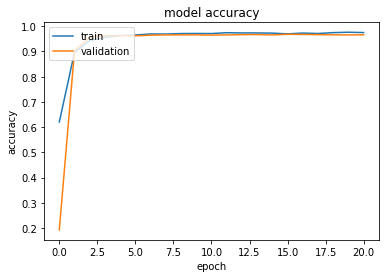

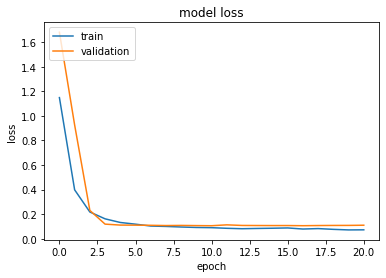

<Figure size 432x288 with 0 Axes>

In [22]:
plot_summary_accuracy(model)
plot_summary_loss(model)

Function to evaluate the model (multiclass problem) with the enumerous metrics to be used

In [11]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, matthews_corrcoef, classification_report, \
    multilabel_confusion_matrix, roc_auc_score, precision_score,recall_score

def model_evaluate(x_test=None, y_test=None, model=None):
    scores = {}
    cm2 = []
  
    y_prob = model.predict(x_test)
    y_pred= np.argmax(y_prob,axis=1)
    y_test=np.argmax(y_test, axis=1)
    
    scores['Accuracy'] = accuracy_score(y_test, y_pred)
    scores['MCC'] = matthews_corrcoef(y_test, y_pred)
    scores['log_loss'] = log_loss(y_test, y_prob)

    
    scores['f1 score weighted'] = f1_score(y_test, y_pred, average = 'weighted')
    scores['f1 score macro'] = f1_score(y_test, y_pred, average = 'macro')
    scores['f1 score micro'] = f1_score(y_test, y_pred, average = 'micro')
    scores['roc_auc ovr'] = roc_auc_score(y_test, y_prob, average = 'weighted', multi_class = 'ovr')
    y_test_reshape = y_test.reshape(y_test.shape[0])  
    scores['roc_auc ovo'] = roc_auc_score(y_test_reshape, y_prob, average = 'weighted', multi_class = 'ovo')
    scores['precision'] = precision_score(y_test, y_pred, average = 'weighted')
    scores['recall'] = recall_score(y_test, y_pred, average = 'weighted')
    cm2 = multilabel_confusion_matrix(y_test, y_pred)
    
    return scores, cm2

In [24]:
scores, cm2 = model_evaluate(X_test, y_test, model=model)

126/126 [==============================] - 1s 3ms/step


In [56]:
print('Scores:', scores)

Scores: {'Accuracy': 0.9636996519144704, 'MCC': 0.9578340727811037, 'log_loss': 0.11440359978796893, 'f1 score weighted': 0.9637173809005386, 'f1 score macro': 0.9629744834870578, 'f1 score micro': 0.9636996519144703, 'roc_auc ovr': 0.9986482406540637, 'roc_auc ovo': 0.9985737903746353, 'precision': 0.9652933895604059, 'recall': 0.9636996519144704}


In [59]:
print('Multiple layers of the confusion matrix:\n', cm2)

Multiple layers of the confusion matrix:
 [[[3377   45]
  [  16  584]]

 [[3411   11]
  [  37  563]]

 [[3409   13]
  [  14  586]]

 [[3416    6]
  [   4  596]]

 [[3552   48]
  [   0  422]]

 [[3401   21]
  [  17  583]]

 [[3420    2]
  [  58  542]]]


Plot the overall distribution of sequences length

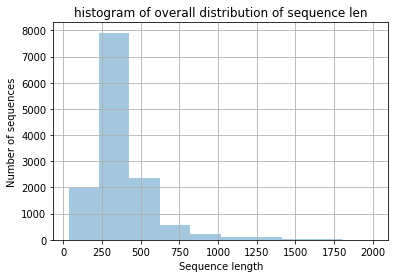

In [27]:
data_new['seq_len'] = data_new['sequence'].apply(lambda x: len(x)) 
data_new['seq_len'].hist(alpha = 0.4, range = [data_new['seq_len'].min(), 2000])
plt.title('histogram of overall distribution of sequence len')
plt.xlabel('Sequence length')
plt.ylabel('Number of sequences')
plt.grid(True)

## Aminoacids encoding with LSTM and multiclass classification

Split dataset into train and test

In [12]:
y = data_feature_y['ec_lev']
x = data_new['sequence']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 32, stratify = y)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (9382,) (9382,)
Test:  (4022,) (4022,)


In [13]:
print(X_train)

11183    MSTRKRRGGAINSRQAQKRTREATSTPEISLEAEPIELVETAGDEI...
7471     MFSFEGDFKTRPKVSLGGASRKEEKASLLHRTQEERRKREEERRRL...
301      MVLMVNLGFVIAEFNRDITYMMEKVAEEHAEFLGATVKYKIVVPGV...
4679     MLLAIPSKGRLLDPTLKLLEAIGMRLLASDERALVVPTSWRDVNVI...
9062     MIDNIWYKPQLGILSYILSPIAFIFSKIAHNRKIRLQNNQYKSKIP...
                               ...                        
6761     MDINKARKAKFDELNSGKNLEISRAIEALGDLECACEFSDTINIKF...
5355     MSIFLKNKQFENITSQEQTKNNYKQLINDIQTLKKDLNAIILAHYY...
4462     MLALGIEGTAHTLGIGIVSEDKVLANVFDTLTTEKGGIHPKEAAEH...
10468    MIKKIIFTVTPIFSIPPRGAAAVETWIYQVAKRLSIPNAIACIKNA...
12296    MRKNKVDIITLGCSKNLVDSEQLMRQFVANGYTVEHDPHKINGEIV...
Name: sequence, Length: 9382, dtype: object


The hot-encoding datasets were recreated with the structure of 21 columns (one for each amino acid) for the entire length of 100 amino acids, for sequences below 100 amino acids they were padded with 0s. Sequences longer than 100 amino acids were ignored. This limitation was applied in order to lessen the pressure on the required hardware.

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def hot_encoded_sequence(sequences, seq_len, alphabet, padding_truncating='post'):
    sequences_integer_ecoded = []
    for seq in sequences:
        char_to_int = dict((c, i) for i, c in enumerate(alphabet))  
        
        int_to_char = dict((i, c) for i, c in enumerate(alphabet))

        integer_encoded = [char_to_int[char] for char in seq]
        sequences_integer_ecoded.append(integer_encoded)

    list_of_sequences_length = pad_sequences(sequences_integer_ecoded, maxlen=seq_len, dtype='int', padding=padding_truncating, truncating=padding_truncating, value=0.0)

   
    encoded = to_categorical(list_of_sequences_length) 
    return list_of_sequences_length, encoded

In [15]:
seq_len = 100
fps_x_train, X_train_encoded = hot_encoded_sequence(sequences = X_train, seq_len = seq_len,
                                            alphabet = 'XARNDCEQGHILKMFPSTWYV', padding_truncating = 'post')
fps_x_test, X_encoded_test = hot_encoded_sequence(sequences = X_test, seq_len = seq_len,
                                            alphabet ='XARNDCEQGHILKMFPSTWYV', padding_truncating = 'post')


print(fps_x_train.shape)
print(fps_x_test.shape)

print(X_train_encoded.shape)
print(X_encoded_test.shape)

(9382, 100)
(4022, 100)
(9382, 100, 21)
(4022, 100, 21)


In [16]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GRU, BatchNormalization, Masking
from tensorflow.keras.layers import Dropout, Bidirectional
from sklearn.metrics import make_scorer
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def lstm_simple(input_dim,len_alphabet,
                        optimizer = 'Adam',
                        bilstm = True,
                        lstm_layers = (128, 128, 64),
                        dense_layers = (64, 64, 32),
                        activation = 'tanh',
                        recurrent_activation = 'sigmoid',
                        dense_activation = "relu",
                        l1 = 1e-5, l2 = 1e-4,
                        dropout_rate = (0, 0.3, 0.3), recurrent_dropout_rate = (0.3, ),
                        dropout_rate_dense = (0.3, ),
                        batchnormalization = (True, ),
                        loss_fun = 'sparse_categorical_crossentropy', activation_fun = None,
                        cv = None, optType = None, param_grid = None, n_iter_search = 15, n_jobs = 4,
                        scoring = make_scorer(matthews_corrcoef)):
    model = Sequential()

    model.add(Input(shape = (input_dim, len_alphabet,), dtype = 'float32', name = 'main_input'))

    model.add(LSTM(64, return_sequences = False))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(7, activation = 'softmax'))
    return model


In [17]:
model = lstm_simple(input_dim = 100, len_alphabet = 21)

es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 25, verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 10, min_lr = 0.00001, verbose = 1)

callbacks = [es, reduce_lr]
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) 

In [18]:
history = model.fit(X_train_encoded, y_train, epochs = 15, batch_size = 256, callbacks = callbacks, 
                        validation_split = 0.3) 

Epoch 1/15
26/26 [==============================] - 8s 193ms/step - loss: 2.3081 - accuracy: 0.1264 - val_loss: 2.1614 - val_accuracy: 0.1655 - lr: 0.0010
Epoch 2/15
26/26 [==============================] - 4s 156ms/step - loss: 2.1654 - accuracy: 0.1631 - val_loss: 2.1346 - val_accuracy: 0.1613 - lr: 0.0010
Epoch 3/15
26/26 [==============================] - 4s 157ms/step - loss: 2.1064 - accuracy: 0.1876 - val_loss: 2.1041 - val_accuracy: 0.1616 - lr: 0.0010
Epoch 4/15
26/26 [==============================] - 4s 159ms/step - loss: 2.0540 - accuracy: 0.2135 - val_loss: 2.0722 - val_accuracy: 0.1634 - lr: 0.0010
Epoch 5/15
26/26 [==============================] - 4s 158ms/step - loss: 1.9940 - accuracy: 0.2500 - val_loss: 2.0404 - val_accuracy: 0.1673 - lr: 0.0010
Epoch 6/15
26/26 [==============================] - 4s 161ms/step - loss: 1.9457 - accuracy: 0.2535 - val_loss: 2.0100 - val_accuracy: 0.1783 - lr: 0.0010
Epoch 7/15
26/26 [==============================] - 4s 158ms/step - lo

In [19]:
tensorflow.keras.backend.clear_session()

In [20]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                22016     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 297       
                                                        

In [21]:
print('Training Accuracy: ', np.mean(history.history['accuracy']))
print('Validation Accuracy: ', np.mean(history.history['val_accuracy']))
print('Training Loss: ', np.mean(history.history['loss']))
print('Validation Loss: ', np.mean(history.history['val_loss']))

Training Accuracy:  0.2605756014585495
Validation Accuracy:  0.2140674978494644
Training Loss:  1.9201117992401122
Validation Loss:  1.9756680727005005


## Blosum encoding

We used a numeric vector to describe each aminoacid in the sequence. But now we use substitution matrices such as the BLOSUM.
The use of substitution and scoring matrices, such as BLOSUM, represents accepted mutations between amino acid pairs. BLOSUM captures evolutionary relationships between AAs.

In [22]:
blosum62 = {
    'A': [4, -1, -2, -2, 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1, 1, 0, -3, -2, 0,-4],
    'R': [-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2, 2, -1, -3, -2, -1, -1, -3, -2, -3,-4],
    'N': [-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2, 1, 0, -4, -2, -3,-4],
    'D': [-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3,-4],
    'C': [0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1,-4],
    'Q': [-1, 1, 0, 0, -3, 5, 2, -2, 0, -3, -2, 1, 0, -3, -1, 0, -1, -2, -1, -2,-4],
    'E': [-1, 0, 0, 2, -4, 2, 5, -2, 0, -3, -3, 1, -2, -3, -1, 0, -1, -3, -2, -2,-4],
    'G': [0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3,-4],
    'H': [-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3,-4],
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3, 4, 2, -3, 1, 0, -3, -2, -1, -3, -1, 3,-4],
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3, 2, 4, -2, 2, 0, -3, -2, -1, -2, -1, 1,-4],
    'K': [-1, 2, 0, -1, -3, 1, 1, -2, -1, -3, -2, 5, -1, -3, -1, 0, -1, -3, -2, -2,-4],
    'M': [-1, -1, -2, -3, -1, 0, -2, -3, -2, 1, 2, -1, 5, 0, -2, -1, -1, -1, -1, 1,-4],
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1, 0, 0, -3, 0, 6, -4, -2, -2, 1, 3, -1,-4],
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7, -1, -1, -4, -3, -2,-4],
    'S': [1, -1, 1, 0, -1, 0, 0, 0, -1, -2, -2, 0, -1, -2, -1, 4, 1, -3, -2, -2,-4],
    'T': [0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 1, 5, -2, -2, 0,-4],
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3,-4],
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2, 2, 7, -1,-4],
    'V': [0, -3, -3, -3, -1, -2, -2, -3, -3, 3, 1, -2, 1, -1, -2, -2, 0, -3, -1, 4,-4],
    'X': [-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,1]
}

Functions to get each aa in protein sequence as a blosum encoding.

In [23]:
def seq_pad(sequences, seq_len, alphabet, padding_truncating = 'post'):
    sequences_integer_ecoded = []
    for seq in sequences:
        char_to_int = dict((c, i) for i, c in enumerate(alphabet))
        int_to_char = dict((i, c) for i, c in enumerate(alphabet))
        
        integer_encoded = [char_to_int[char] for char in seq]
        sequences_integer_ecoded.append(integer_encoded)

    list_of_sequences_length = pad_sequences(sequences_integer_ecoded, maxlen = seq_len, dtype = 'int32',
                                             padding = padding_truncating, truncating = padding_truncating, value = 0)
    print(int_to_char)
    new_seq = []
    for seq in list_of_sequences_length:
        integer_encoded = [int_to_char[i] for i in seq]
        new_seq.append(integer_encoded)
        
    return new_seq


def blosum(sequences):
    bl = []
    for seq in sequences:
        x = [blosum62.get(i) for i in seq]
        bl.append(x)
    return bl

In [24]:
seq_len = 100
train = seq_pad(sequences = X_train, seq_len = seq_len,
                                            alphabet = 'XARNDCEQGHILKMFPSTWYV', padding_truncating = 'post')
test = seq_pad(sequences = X_test, seq_len = seq_len,
                                            alphabet = 'XARNDCEQGHILKMFPSTWYV', padding_truncating = 'post')

{0: 'X', 1: 'A', 2: 'R', 3: 'N', 4: 'D', 5: 'C', 6: 'E', 7: 'Q', 8: 'G', 9: 'H', 10: 'I', 11: 'L', 12: 'K', 13: 'M', 14: 'F', 15: 'P', 16: 'S', 17: 'T', 18: 'W', 19: 'Y', 20: 'V'}
{0: 'X', 1: 'A', 2: 'R', 3: 'N', 4: 'D', 5: 'C', 6: 'E', 7: 'Q', 8: 'G', 9: 'H', 10: 'I', 11: 'L', 12: 'K', 13: 'M', 14: 'F', 15: 'P', 16: 'S', 17: 'T', 18: 'W', 19: 'Y', 20: 'V'}


In [25]:
train_bl = np.array(blosum(train))
test_bl=np.array(blosum(test))

In [26]:
print('train', train_bl.shape) 
print('test', test_bl.shape)

train (9382, 100, 21)
test (4022, 100, 21)


In [27]:
model = lstm_simple(input_dim = 100, len_alphabet = 21)

es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 15, verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 0.00001, verbose = 1)

callbacks = [es, reduce_lr]
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [28]:
history = model.fit(train_bl, y_train, epochs = 80, batch_size = 256, callbacks = callbacks, 
                        validation_split = 0.3) 

Epoch 1/80
26/26 [==============================] - 8s 197ms/step - loss: 2.6692 - accuracy: 0.1198 - val_loss: 2.1689 - val_accuracy: 0.1378 - lr: 0.0010
Epoch 2/80
26/26 [==============================] - 5s 174ms/step - loss: 2.3821 - accuracy: 0.1392 - val_loss: 2.1219 - val_accuracy: 0.1623 - lr: 0.0010
Epoch 3/80
26/26 [==============================] - 4s 170ms/step - loss: 2.2690 - accuracy: 0.1547 - val_loss: 2.0773 - val_accuracy: 0.1773 - lr: 0.0010
Epoch 4/80
26/26 [==============================] - 4s 161ms/step - loss: 2.1792 - accuracy: 0.1826 - val_loss: 2.0547 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/80
26/26 [==============================] - 5s 195ms/step - loss: 2.1258 - accuracy: 0.1929 - val_loss: 2.0303 - val_accuracy: 0.2046 - lr: 0.0010
Epoch 6/80
26/26 [==============================] - 7s 257ms/step - loss: 2.0794 - accuracy: 0.1955 - val_loss: 1.9922 - val_accuracy: 0.2089 - lr: 0.0010
Epoch 7/80
26/26 [==============================] - 7s 256ms/step - lo

In [29]:
tensorflow.keras.backend.clear_session()

In [30]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                22016     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 297       
                                                        

In [31]:
print('Training Accuracy: ', np.mean(history.history['accuracy']))
print('Validation Accuracy: ', np.mean(history.history['val_accuracy']))
print('Training Loss: ', np.mean(history.history['loss']))
print('Validation Loss: ', np.mean(history.history['val_loss']))

Training Accuracy:  0.5379113408102505
Validation Accuracy:  0.49717609994653345
Training Loss:  1.2605173458223757
Validation Loss:  1.3677933648012686


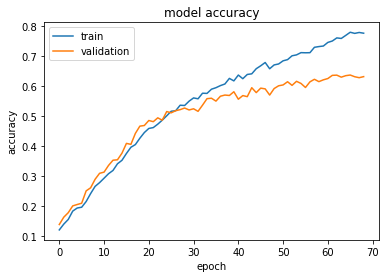

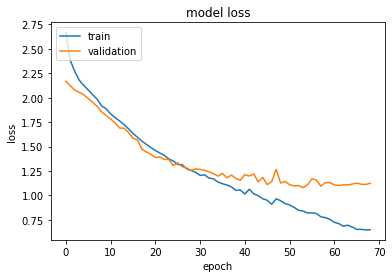

<Figure size 432x288 with 0 Axes>

In [32]:
plot_summary_accuracy(model)
plot_summary_loss(model)

In [67]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, multilabel_confusion_matrix

def model_evaluate_multi(X_test=None, y_test=None, model=None):
    scores = {}
  
    y_prob = model.predict(X_test) 
    y_pred = np.argmax(y_prob,axis=1)

    scores['Accuracy'] = accuracy_score(y_test, y_pred)
    scores['MCC'] = matthews_corrcoef(y_test, y_pred)
    scores['precision'] = precision_score(y_test, y_pred, average='weighted')
    scores['recall'] = recall_score(y_test, y_pred, average='weighted')
    cm2 = multilabel_confusion_matrix(y_test, y_pred)
    
    return scores, cm2

In [55]:
scores, cm2 = model_evaluate_multi(X_test=test_bl, y_test=y_test, model=model)

126/126 [==============================] - 1s 11ms/step


In [56]:
scores

{'Accuracy': 0.6176031824962706,
 'MCC': 0.553728883467832,
 'precision': 0.6231810750158294,
 'recall': 0.6176031824962706}

## Z scale encoding

Z scale represents physicochemical properties of each aminoacid.
Physicochemical character based schemes are usually derived by PCA of a large property matrix used to described individual AAs. 

Z-scales are 5 dimension vectors based on 26 physicochemical properties of the AAs. Each Z scale represent an amino-acid property including lipophilicity, Steric properties, Electronic properties, electronegativity, heat of formation, electrophilicity and hardness.

In [ ]:
zs = {
    'A': [0.24, -2.32, 0.60, -0.14, 1.30],  
    'C': [0.84, -1.67, 3.71, 0.18, -2.65],  
    'D': [3.98, 0.93, 1.93, -2.46, 0.75],  
    'E': [3.11, 0.26, -0.11, -0.34, -0.25],  
    'F': [-4.22, 1.94, 1.06, 0.54, -0.62],  
    'G': [2.05, -4.06, 0.36, -0.82, -0.38],  
    'H': [2.47, 1.95, 0.26, 3.90, 0.09],  
    'I': [-3.89, -1.73, -1.71, -0.84, 0.26],  
    'K': [2.29, 0.89, -2.49, 1.49, 0.31],  
    'L': [-4.28, -1.30, -1.49, -0.72, 0.84],  
    'M': [-2.85, -0.22, 0.47, 1.94, -0.98],  
    'N': [3.05, 1.62, 1.04, -1.15, 1.61],  
    'P': [-1.66, 0.27, 1.84, 0.70, 2.00],  
    'Q': [1.75, 0.50, -1.44, -1.34, 0.66],  
    'R': [3.52, 2.50, -3.50, 1.99, -0.17],  
    'S': [2.39, -1.07, 1.15, -1.39, 0.67], 
    'T': [0.75, -2.18, -1.12, -1.46, -0.40],  
    'V': [-2.59, -2.64, -1.54, -0.85, -0.02],  
    'W': [-4.36, 3.94, 0.59, 3.44, -1.59],  
    'Y': [-2.54, 2.44, 0.43, 0.04, -1.47], 
    'X': [0.0, 0.0, 0.0, 0.0, 0.0]
}

Function to get each aa in protein sequence as z scale encoding

In [ ]:
def zscale(sequences):
    zl = []
    for seq in sequences:
        x = [zs.get(i) for i in seq]
        zl.append(x)
    return zl

In [57]:
train_zl = np.array(zscale(train))
test_zl=np.array(zscale(test))

In [58]:
print('train', train_zl.shape)  
print('test', test_zl.shape)

train (9382, 100, 5)
test (4022, 100, 5)


In [61]:
model = lstm_simple(input_dim = 100,len_alphabet=5)

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=0.00001, verbose=1)

callbacks = [es, reduce_lr]
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [62]:
history = model.fit(train_zl, y_train, epochs=80, batch_size=256, callbacks=callbacks, validation_split = 0.3) 

Epoch 1/80
26/26 [==============================] - 6s 138ms/step - loss: 2.6763 - accuracy: 0.1215 - val_loss: 2.1739 - val_accuracy: 0.1496 - lr: 0.0010
Epoch 2/80
26/26 [==============================] - 3s 109ms/step - loss: 2.3774 - accuracy: 0.1573 - val_loss: 2.1497 - val_accuracy: 0.1478 - lr: 0.0010
Epoch 3/80
26/26 [==============================] - 3s 103ms/step - loss: 2.2744 - accuracy: 0.1709 - val_loss: 2.1234 - val_accuracy: 0.1499 - lr: 0.0010
Epoch 4/80
26/26 [==============================] - 3s 102ms/step - loss: 2.1955 - accuracy: 0.1867 - val_loss: 2.0951 - val_accuracy: 0.1574 - lr: 0.0010
Epoch 5/80
26/26 [==============================] - 3s 106ms/step - loss: 2.1394 - accuracy: 0.1998 - val_loss: 2.0690 - val_accuracy: 0.1755 - lr: 0.0010
Epoch 6/80
26/26 [==============================] - 3s 104ms/step - loss: 2.0763 - accuracy: 0.2149 - val_loss: 2.0320 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 7/80
26/26 [==============================] - 3s 127ms/step - lo

In [63]:
tensorflow.keras.backend.clear_session()

In [64]:
print('Training Accuracy: ', np.mean(history.history['accuracy']))
print('Validation Accuracy: ', np.mean(history.history['val_accuracy']))
print('Training Loss: ', np.mean(history.history['loss']))
print('Validation Loss: ', np.mean(history.history['val_loss']))

Training Accuracy:  0.43950224909144386
Validation Accuracy:  0.4203687484415484
Training Loss:  1.473758381856999
Validation Loss:  1.5107388294918436


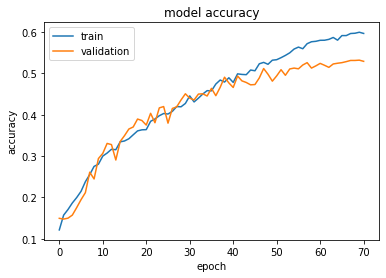

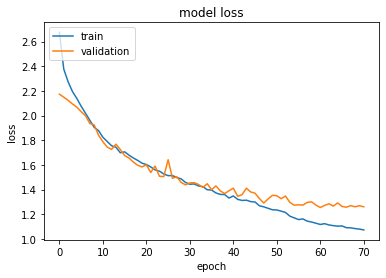

<Figure size 432x288 with 0 Axes>

In [65]:
plot_summary_accuracy(model)
plot_summary_loss(model)

In [69]:
scores, cm2 = model_evaluate_multi(X_test=test_zl, y_test=y_test, model=model)
scores

126/126 [==============================] - 2s 12ms/step


{'Accuracy': 0.538040775733466,
 'MCC': 0.46062436832725373,
 'precision': 0.5455593576443954,
 'recall': 0.538040775733466}

## Embedding encoding

Using the embedding layers we encoded a learnable part of the model. The model encodes and extracts patterns in data relevant and specific for the problem in question.

In [76]:
def lstm_embedding(output_dim,input_dim,
                               optimizer='Adam',
                               lstm_layers=(32,),
                               activation='tanh',
                               recurrent_activation='sigmoid',
                               dropout_rate=(0.1,),
                               l1=1e-5, l2=1e-4,
                               dense_layers=(32, 16),
                               dropout_rate_dense=(0.1, 0.1),
                               dense_activation="relu", loss='sparse_categorical_crossentropy'):
    model = Sequential()    
    len_alphabet = 21

    model.add(Embedding(input_dim=len_alphabet, output_dim=output_dim))
    model.add(LSTM(64, return_sequences = False))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(7, activation='softmax'))
    return model

In [74]:
model = lstm_embedding(output_dim = 5, input_dim = 100)

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=0.00001, verbose=1)

callbacks = [es, reduce_lr]
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [77]:
history = model.fit(fps_x_train, y_train, epochs=80, batch_size=256, callbacks=callbacks, validation_split = 0.3) 


Epoch 1/80
26/26 [==============================] - 3s 126ms/step - loss: 1.9425 - accuracy: 0.2628 - val_loss: 2.0307 - val_accuracy: 0.1769 - lr: 0.0010
Epoch 2/80
26/26 [==============================] - 3s 122ms/step - loss: 1.9102 - accuracy: 0.2720 - val_loss: 2.0095 - val_accuracy: 0.1496 - lr: 0.0010
Epoch 3/80
26/26 [==============================] - 4s 146ms/step - loss: 1.8813 - accuracy: 0.2723 - val_loss: 1.9866 - val_accuracy: 0.1496 - lr: 0.0010
Epoch 4/80
26/26 [==============================] - 4s 150ms/step - loss: 1.8558 - accuracy: 0.2779 - val_loss: 1.9674 - val_accuracy: 0.1474 - lr: 0.0010
Epoch 5/80
26/26 [==============================] - 4s 149ms/step - loss: 1.8411 - accuracy: 0.2711 - val_loss: 1.9521 - val_accuracy: 0.1702 - lr: 0.0010
Epoch 6/80
26/26 [==============================] - 4s 146ms/step - loss: 1.8208 - accuracy: 0.2811 - val_loss: 1.9424 - val_accuracy: 0.1691 - lr: 0.0010
Epoch 7/80
26/26 [==============================] - 4s 145ms/step - lo

In [78]:
tensorflow.keras.backend.clear_session()

In [79]:
print('Training Accuracy: ', np.mean(history.history['accuracy']))
print('Validation Accuracy: ', np.mean(history.history['val_accuracy']))
print('Training Loss: ', np.mean(history.history['loss']))
print('Validation Loss: ', np.mean(history.history['val_loss']))

Training Accuracy:  0.30913088377565145
Validation Accuracy:  0.25397424725815654
Training Loss:  1.756753958761692
Validation Loss:  1.8237334825098515


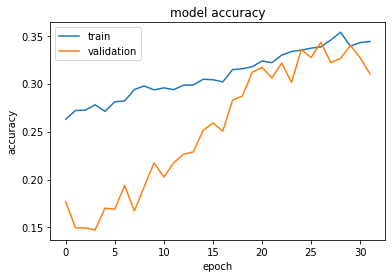

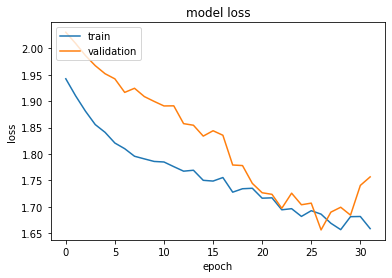

<Figure size 432x288 with 0 Axes>

In [80]:
plot_summary_accuracy(model)
plot_summary_loss(model)

In [82]:
scores, cm2 = model_evaluate_multi(X_test=fps_x_test, y_test=y_test, model=model)
scores

126/126 [==============================] - 2s 13ms/step


{'Accuracy': 0.3112879164594729,
 'MCC': 0.20525444447948726,
 'precision': 0.33312584602050244,
 'recall': 0.3112879164594729}

In [83]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 5)           105       
                                                                 
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                      

Get the weights of the embedding

In [84]:
emb_wei_5 = pd.DataFrame(model.layers[0].get_weights()[0])
emb_wei_5

,0,1,2,3,4
0,-0.084863,-0.018710,0.018058,-0.112691,-0.114571
1,-0.086352,0.090027,-0.035261,0.003998,0.003221
2,0.004539,-0.018867,0.001237,-0.117329,-0.089070
3,0.108309,-0.046057,-0.110385,-0.035461,0.088830
4,-0.029379,-0.080477,-0.028824,-0.090675,-0.005313
5,0.182208,0.110061,-0.089275,0.023507,-0.056136
6,0.003138,-0.009290,-0.120747,0.016459,-0.068218
7,0.041138,0.008096,-0.025083,-0.086749,0.025290
8,0.025089,-0.027470,0.012634,0.051160,0.016339
9,-0.058176,-0.014777,-0.058160,-0.036379,0.055234


In [85]:
model = lstm_embedding(output_dim = 21, input_dim = 100)

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=0.00001, verbose=1)

callbacks = [es, reduce_lr]
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [86]:
history = model.fit(fps_x_train, y_train, epochs=80, batch_size=256, callbacks=callbacks, 
                        validation_split = 0.3) 

Epoch 1/80
26/26 [==============================] - 5s 127ms/step - loss: 2.1757 - accuracy: 0.1533 - val_loss: 2.1618 - val_accuracy: 0.1496 - lr: 0.0010
Epoch 2/80
26/26 [==============================] - 3s 108ms/step - loss: 2.1052 - accuracy: 0.2144 - val_loss: 2.1202 - val_accuracy: 0.1492 - lr: 0.0010
Epoch 3/80
26/26 [==============================] - 3s 115ms/step - loss: 2.0249 - accuracy: 0.2429 - val_loss: 2.0811 - val_accuracy: 0.1496 - lr: 0.0010
Epoch 4/80
26/26 [==============================] - 3s 120ms/step - loss: 1.9533 - accuracy: 0.2715 - val_loss: 2.0415 - val_accuracy: 0.1496 - lr: 0.0010
Epoch 5/80
26/26 [==============================] - 3s 130ms/step - loss: 1.9033 - accuracy: 0.2837 - val_loss: 2.0122 - val_accuracy: 0.1492 - lr: 0.0010
Epoch 6/80
26/26 [==============================] - 3s 131ms/step - loss: 1.8687 - accuracy: 0.2869 - val_loss: 1.9855 - val_accuracy: 0.1492 - lr: 0.0010
Epoch 7/80
26/26 [==============================] - 3s 127ms/step - lo

In [87]:
tensorflow.keras.backend.clear_session()

In [88]:
print('Training Accuracy: ', np.mean(history.history['accuracy']))
print('Validation Accuracy: ', np.mean(history.history['val_accuracy']))
print('Training Loss: ', np.mean(history.history['loss']))
print('Validation Loss: ', np.mean(history.history['val_loss']))

Training Accuracy:  0.4510716464370489
Validation Accuracy:  0.41952486615628004
Training Loss:  1.4553202450275422
Validation Loss:  1.5087681859731674


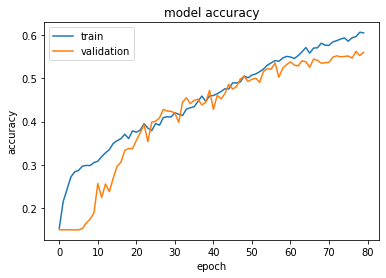

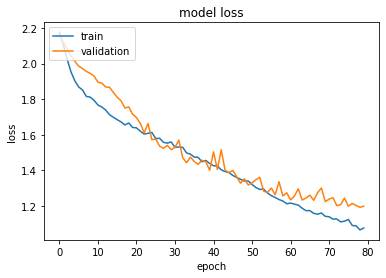

<Figure size 432x288 with 0 Axes>

In [89]:
plot_summary_accuracy(model)
plot_summary_loss(model)

In [90]:
scores, cm2 = model_evaluate_multi(X_test=fps_x_test, y_test=y_test, model=model)
scores

126/126 [==============================] - 2s 12ms/step


{'Accuracy': 0.5529587270014918,
 'MCC': 0.47825784218988676,
 'precision': 0.5572879772427533,
 'recall': 0.5529587270014918}

In [91]:
emb_wei_20 = pd.DataFrame(model.layers[0].get_weights()[0])
emb_wei_20

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.053338,0.033929,0.051067,0.123381,-0.179913,-0.022127,0.040525,0.070944,-0.101606,0.148907,...,0.005309,-0.031794,-0.163214,0.032918,-0.020311,0.197460,-0.122145,-0.015890,-0.003518,-0.058587
1,-0.031193,0.025194,-0.055595,-0.129727,-0.038532,0.051218,-0.155196,-0.053563,-0.098224,0.041865,...,0.027835,-0.162362,0.130632,-0.060416,-0.003061,-0.060421,-0.008719,-0.009680,-0.078060,-0.071187
2,0.184078,0.046660,0.056890,0.139943,-0.268463,-0.001925,0.128390,-0.009626,-0.034221,-0.003024,...,-0.025423,0.199758,0.044745,0.133079,-0.156057,-0.018976,-0.139561,-0.010300,-0.006795,0.108578
3,0.034416,-0.168607,-0.081654,-0.059166,-0.197936,0.033481,0.023545,-0.139698,0.057456,-0.066464,...,-0.011697,0.145281,-0.043916,-0.057001,0.223965,-0.000208,-0.164304,-0.050187,-0.101795,-0.183372
4,0.167268,-0.141584,0.173748,0.069648,0.187995,0.074373,-0.061871,-0.077004,0.131392,0.121225,...,-0.036032,0.065705,0.137448,0.140464,0.095710,0.286364,0.106453,0.052625,-0.087874,-0.097590
5,-0.043721,0.019643,-0.194043,0.079527,-0.027359,-0.138296,-0.072674,-0.229619,0.172968,0.041026,...,-0.061804,0.253975,-0.098145,-0.290245,0.036026,-0.012117,0.002151,-0.295388,-0.126162,0.133925
6,0.089018,-0.069543,0.103571,-0.139709,0.090579,-0.165302,0.000211,0.128535,0.148575,0.159911,...,-0.157913,0.113081,0.104805,0.072172,-0.046198,0.017379,-0.027872,0.071620,-0.066978,-0.114861
7,0.022229,-0.073848,-0.123894,-0.048409,-0.033267,-0.034319,0.158264,-0.178237,-0.054480,0.149062,...,-0.046081,0.003660,0.163867,0.015188,-0.186401,0.053432,-0.022532,0.063156,-0.086029,-0.082179
8,-0.041188,0.064167,0.007031,0.159053,-0.029425,-0.083283,0.005326,-0.053031,0.096000,-0.069708,...,-0.050599,-0.156960,-0.023855,0.019256,-0.011443,-0.191847,-0.154204,0.033415,-0.056157,0.287040
9,-0.002601,-0.156841,0.057662,0.067471,0.254234,-0.122196,0.026910,0.071591,0.037374,-0.186945,...,0.108943,0.243407,0.090909,0.007693,0.019642,-0.363039,0.054124,-0.085779,0.002862,-0.215660


## Graphics of embeddings

In [92]:
hotencoded = {
    'A': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'R': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'N': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'D': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'C': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Q': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'E': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'G': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'H': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'I': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'L': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'K': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'M': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'F': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'P': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    'S': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    'T': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'W': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Y': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'V': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    'X': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
}


alphabet="XARNDCEQGHILKMFPSTWYV"
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
row_names = char_to_int.keys()

emb_wei_5['alphabet'] = row_names
emb_wei_5 = emb_wei_5.set_index('alphabet')

emb_wei_20['alphabet'] = row_names
emb_wei_20 = emb_wei_20.set_index('alphabet')

Calculate similarities between aminoacids

In [93]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

b = pd.DataFrame.from_dict(blosum62, orient='index')
z = pd.DataFrame.from_dict(zs, orient='index')
h = pd.DataFrame.from_dict(hotencoded, orient='index')

bcs=cosine_similarity(b)
bcs=pd.DataFrame(bcs, index=blosum62.keys(), columns=blosum62.keys())

zcs=cosine_similarity(z)
zcs=pd.DataFrame(zcs, index=zs.keys(), columns=zs.keys())

hcs=cosine_similarity(h)
hcs=pd.DataFrame(hcs, index=hotencoded.keys(), columns=hotencoded.keys())

e5cs = cosine_similarity(emb_wei_5)
e5cs=pd.DataFrame(e5cs, index=row_names,columns=row_names)

e20cs = cosine_similarity(emb_wei_20)
e20cs=pd.DataFrame(e20cs, index=row_names,columns=row_names)


Comparation and visualisation of similarities

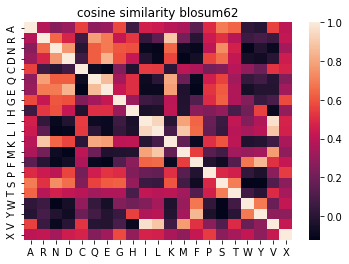

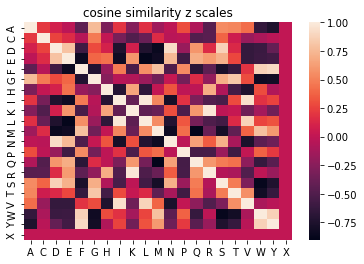

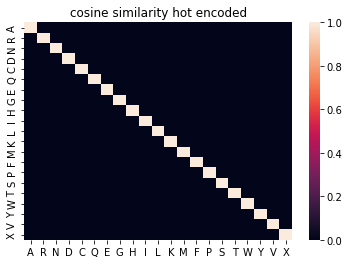

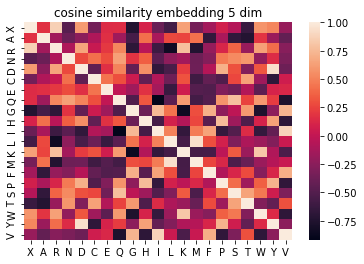

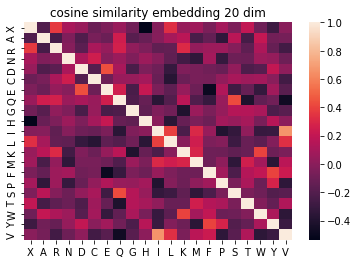

In [94]:
bu = sns.heatmap(bcs, xticklabels=blosum62.keys(), yticklabels=blosum62.keys())
plt.title('cosine similarity blosum62')
plt.show()

zu = sns.heatmap(zcs, xticklabels=zs.keys(), yticklabels=zs.keys())
plt.title('cosine similarity z scales')
plt.show()

hu = sns.heatmap(hcs, xticklabels=hotencoded.keys(), yticklabels=hotencoded.keys())
plt.title('cosine similarity hot encoded')
plt.show()


e5u = sns.heatmap(e5cs, xticklabels=char_to_int.keys(), yticklabels=char_to_int.keys())
plt.title('cosine similarity embedding 5 dim')
plt.show()

e20u = sns.heatmap(e20cs, xticklabels=char_to_int.keys(), yticklabels=char_to_int.keys())
plt.title('cosine similarity embedding 20 dim')
plt.show()

The white squares indicate more similarities. The blossum is a evolutionary property and the z scale shows the most similarities.
The hotencoding shows no similarities between aa.